In [1]:
import os
import json
import zipfile
from collections import OrderedDict

import numpy as np
import pandas as pd
import xarray as xr
import scipy.sparse as sp
import requests
import pgeocode

import atlite
import geopandas as gpd
import cartopy.io.shapereader as shpreader
import matplotlib.pyplot as plt

from utils.jp_map_processor import load_jp_map, preprocess_jp_map, jp_main_cities

In [2]:
# ============================================================================ #
# load config
# ============================================================================ #

if os.path.exists("config.json"):
	with open("config.json") as config_file:
		config = json.load(config_file)
else:
	config = dict()

japan_era5_cutout_2020 = config.get('japan_era5_cutout_2020', 'data/ref/japan_era5_cutout_2020.nc')
japan_era5_cutout_2020 = os.path.expanduser(japan_era5_cutout_2020)

In [3]:
# ============================================================================ #
# Load Japan GIS Data
# ============================================================================ #

geo_fileloc = os.path.join("data", "ref", "jp_map_simple.geojson")
gdf = load_jp_map(geo_fileloc)
gdf = preprocess_jp_map(gdf)

# ============================================================================ #
# Identify the bounds of Japan
# ============================================================================ #

x1, y1, x2, y2 = gdf.total_bounds
print(x1, y1, x2, y2)

122.93386501935535 24.045615815147176 148.8930330602277 45.55682258161877


In [4]:
# ============================================================================ #
# Define a spatial and temporal Cutout for ERA5 data using atlite
# ============================================================================ #

cutout = atlite.Cutout(
    japan_era5_cutout_2020,
    module="era5",
    x=slice(x1 - 0.2, x2 + 0.2),
    y=slice(y1 - 0.2, y2 + 0.2),
    chunks={"time": 100},
    time="2020",
)

/home/matthew/GitHub/esm-jp-major-cities-rpv-potential/.venv/lib/python3.10/site-packages/atlite/cutout.py:190: UserWarning: Arguments module, x, y, time are ignored, since cutout is already built.
  warn(


In [5]:
# ============================================================================ #
# Sample Cutout Data
# ============================================================================ #

cutout.data

<xarray.Dataset>
Dimensions:           (x: 73, y: 65, time: 8784)
Coordinates:
  * x                 (x) float64 128.0 128.2 128.5 128.8 ... 145.5 145.8 146.0
  * y                 (y) float64 30.0 30.25 30.5 30.75 ... 45.5 45.75 46.0
  * time              (time) datetime64[ns] 2020-01-01 ... 2020-12-31T23:00:00
    lon               (x) float64 dask.array<chunksize=(73,), meta=np.ndarray>
    lat               (y) float64 dask.array<chunksize=(65,), meta=np.ndarray>
Data variables: (12/13)
    height            (y, x) float32 dask.array<chunksize=(65, 73), meta=np.ndarray>
    wnd100m           (time, y, x) float32 dask.array<chunksize=(100, 65, 73), meta=np.ndarray>
    wnd_azimuth       (time, y, x) float32 dask.array<chunksize=(100, 65, 73), meta=np.ndarray>
    roughness         (time, y, x) float32 dask.array<chunksize=(100, 65, 73), meta=np.ndarray>
    influx_toa        (time, y, x) float32 dask.array<chunksize=(100, 65, 73), meta=np.ndarray>
    influx_direct     (time, y, x) float32 dask.array<chunksize=(100, 65, 73), meta=np.ndarray>
    ...                ...
    albedo            (time, y, x) float32 dask.array<chunksize=(100, 65, 73), meta=np.ndarray>
    solar_altitude    (time, y, x) float64 dask.array<chunksize=(100, 65, 73), meta=np.ndarray>
    solar_azimuth     (time, y, x) float64 dask.array<chunksize=(100, 65, 73), meta=np.ndarray>
    temperature       (time, y, x) float32 dask.array<chunksize=(100, 65, 73), meta=np.ndarray>
    soil temperature  (time, y, x) float32 dask.array<chunksize=(100, 65, 73), meta=np.ndarray>
    runoff            (time, y, x) float32 dask.array<chunksize=(100, 65, 73), meta=np.ndarray>
Attributes:
    module:             era5
    prepared_features:  ['influx', 'runoff', 'height', 'temperature', 'wind']
    chunksize_time:     100
    Conventions:        CF-1.6
    history:            2024-04-02 04:10:28 GMT by grib_to_netcdf-2.25.1: /op...

In [6]:
# ============================================================================ #
# Calculate the time series of capacity factors for CSi photovoltaic panels, 
# tilted at 35° and facing south, over the specified spatial and temporal cutout.
# ============================================================================ #

pv_out_cf = cutout.pv(
    panel="CSi", orientation={"slope": 35.0, "azimuth": 180.0}, capacity_factor=True, capacity_factor_timeseries=True
)

[########################################] | 100% Completed | 124.86 s


In [7]:
def get_hourly_gen(pv_out, lat, long, hourly_index):
	data = pv_out.sel(x=long, y=lat, method='nearest')
	time_utc = pd.to_datetime(data.time.values).tz_localize('UTC')
	time_jst = time_utc.tz_convert('Asia/Tokyo')
	data_values = list(data.values)
	dfx = pd.DataFrame(data={'values': data_values}, index=time_jst)
	dfx = dfx.loc['2020-01-02': '2020-12-31']
	dfx.index = hourly_index_2021
	return dfx

(128.0, 150.0)

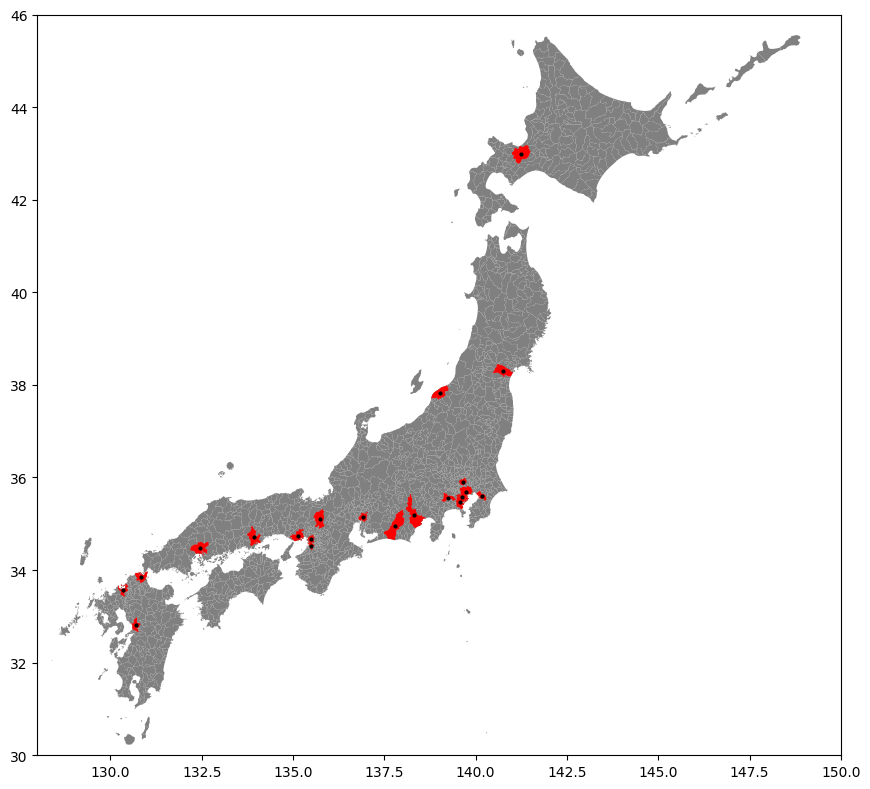

In [8]:
# ============================================================================ #
# Extract centroid of each major cities
# ============================================================================ #
gdf_main_cities = gdf[gdf['N03_004'].isin(jp_main_cities)].copy()

gdf_projected = gdf_main_cities.to_crs(epsg=3857)
gdf_projected['centroid'] = gdf_projected.geometry.centroid
centroids = gdf_projected.set_geometry('centroid').to_crs(epsg=4326)
gdf_main_cities['centroid_long'] = centroids.geometry.x
gdf_main_cities['centroid_lat'] = centroids.geometry.y

fig, ax = plt.subplots(figsize=(12, 8))
plt.tight_layout()

gdf.plot(ax=ax, color='grey')
gdf_main_cities.plot(ax=ax, color='red')
ax.plot(gdf_main_cities['centroid_long'], gdf_main_cities['centroid_lat'], marker='o', color='k', lw=0, markersize=2)

ax.set_ylim(30,46)
ax.set_xlim(128,150)


In [9]:
# ============================================================================ #
# Calculate the Hourly PV Generation
# ============================================================================ #

hourly_index_2021 = pd.date_range(
    start="2022-01-01", end="2022-12-31 23:00:00", freq="H"
)

pv_gen_data = []
for _, row in gdf_main_cities.iterrows():
    muni_name = row["N03_004"]
    pv_gen_data.append(
        get_hourly_gen(
            pv_out_cf, row["centroid_lat"], row["centroid_long"], hourly_index_2021
        )["values"].to_frame(muni_name)
    )

pv_gen_data = pd.concat(pv_gen_data, axis=1)
pv_gen_data

,札幌市,仙台市,さいたま市,千葉市,特別区部,横浜市,川崎市,相模原市,新潟市,静岡市,...,名古屋市,京都市,大阪市,堺市,神戸市,岡山市,広島市,北九州市,福岡市,熊本市
2022-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-12-31 20:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-12-31 21:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-12-31 22:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# ============================================================================ #
# Generate and export hourly capacity factor data for major cities for FY2022,  
# covering the period from April 2022 to March 2023.
# ============================================================================ #

hourly_index_2022 = pd.date_range(
    start="2022-01-01", end="2022-12-31 23:00:00", freq="H"
)
pv_gen_data_2022 = pv_gen_data.copy()
pv_gen_data_2022.index = hourly_index_2022

hourly_index_2023 = pd.date_range(
    start="2023-01-01", end="2023-12-31 23:00:00", freq="H"
)
pv_gen_data_2023 = pv_gen_data.copy()
pv_gen_data_2023.index = hourly_index_2023
pv_gen_2022_2023 = pd.concat([pv_gen_data_2022, pv_gen_data_2023])

pv_gen_fy2022 = pv_gen_2022_2023.loc['2022-04':'2023-03']
pv_gen_fy2022.to_csv('data/ref/pv_gen_kwh_per_kw_hourly_main_cities_fy2022.csv')